# Image Classification

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
import matplotlib.pyplot as plt 

In [ ]:
trans = transforms.ToTensor()

## Getting the dataset

In [ ]:
mnist_train = torchvision.datasets.FashionMNIST(
    root = "../data", train = True, transform=trans, download=True
)

mnist_test = torchvision.datasets.FashionMNIST(
    root = "../data", train = False, transform=trans, download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [ ]:
print(len(mnist_train))
print(len(mnist_test))

print(mnist_train[0][0].shape)

60000
10000
torch.Size([1, 28, 28])


In [ ]:
def get_fmnist_labels(labels) : 
  text_labels = ["tshirt", "trouser", "pullover", "dress", "coat",
                 "sandal", "shirt", "sneaker", "bag", "ankle boot"]
  return [text_labels[int(i)] for i in labels]

## Visualizing a part of the data

In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5) :

  FIGSIZE = (num_cols*scale, num_rows*scale)
  fig, axes = plt.subplots(num_rows, num_cols, figsize=FIGSIZE)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)) :
    if torch.is_tensor(img) :
      ax.imshow(img.numpy())
    else : 
      ax.imshow(img)

    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles : 
      ax.set_title(titles[i])
  fig.tight_layout()
  return axes

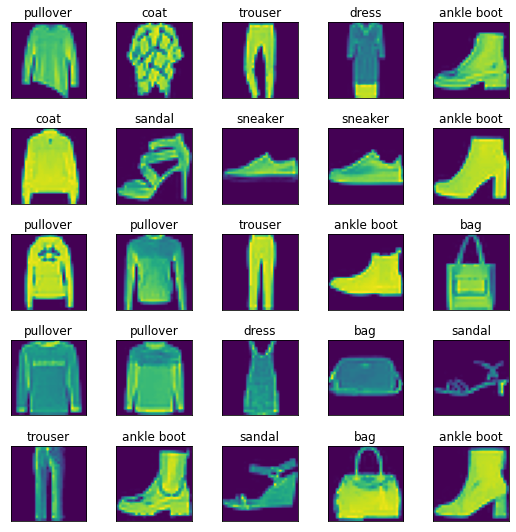

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=25, shuffle=True)))
show_images(X.reshape(25, 28, 28), 5, 5, titles=get_fmnist_labels(y))
plt.show()

## Minibatch reading

In [ ]:
BATCH_SIZE = 256

train_iter = data.DataLoader(mnist_train, BATCH_SIZE, shuffle=True)
test_iter = data.DataLoader(mnist_test, BATCH_SIZE, shuffle=False)

In [ ]:
for (X, y) in train_iter : 
  print(X.shape, y.shape)
  break

torch.Size([256, 1, 28, 28]) torch.Size([256])


## Model

In [ ]:
INPUTS = 28*28  # Pixels in image
OUTPUTS = 10  # 10 classes

In [ ]:
def softmax(X) :
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp/partition

In [ ]:
def net(x) : 
  return softmax(torch.matmul(x.reshape(-1, W.shape[0]), W)+b)

In [ ]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

In [ ]:
def accuracy(y_hat, y) :
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(torch.LongTensor)==y
  return float(cmp.type(torch.LongTensor).sum())/len(cmp)

In [ ]:
def eval_accuracy(net, data_iter) :
  net.eval()
  t = 0
  s = 0
  with torch.no_grad :
    for f, l in data_iter : 
      s += accuracy(net(f), l)
      t += 1
  return s/t

In [ ]:
W = torch.normal(0, 0.01, size=(INPUTS, OUTPUTS), requires_grad = True)
b = torch.zeros(OUTPUTS, requires_grad=True)

NUM_EPOCHS = 10
loss = cross_entropy
lr = 0.1
optimizer = torch.optim.SGD([W,b], lr=lr)

losses = []
accuracies = []
val_accuracies = []
val_losses = []

for epoch in range(NUM_EPOCHS) :
  for f, l in train_iter :
    lo = loss(net(f), l)
    optimizer.zero_grad()
    lo.mean().backward()
    optimizer.step()
  
  with torch.no_grad():
    l_loss = []
    l_acc = []
    for f, l in train_iter :
      y_hat = net(f)
      lo = loss(y_hat, l)
      l_loss.append(lo.mean())
      l_acc.append(accuracy(y_hat, l))
    losses.append(torch.tensor(l_loss).mean())
    accuracies.append(torch.tensor(l_acc).mean())

  with torch.no_grad():
    l_loss = []
    l_acc = []
    for f, l in test_iter :
      y_hat = net(f)
      lo = loss(y_hat, l)
      l_loss.append(lo.mean())
      l_acc.append(accuracy(y_hat, l))
    val_losses.append(torch.tensor(l_loss).mean())
    val_accuracies.append(torch.tensor(l_acc).mean())

  print(f"Epoch : {epoch}, Loss : {losses[epoch]:f}, Val_Loss : {val_losses[epoch]:f},\
  Accuracy : {accuracies[epoch]:f}, Val_Accuracy : {val_accuracies[epoch]:f}")  

Epoch : 0, Loss : 0.628190, Val_Loss : 0.646591,  Accuracy : 0.783804, Val_Accuracy : 0.774609
Epoch : 1, Loss : 0.554791, Val_Loss : 0.575694,  Accuracy : 0.815365, Val_Accuracy : 0.801562
Epoch : 2, Loss : 0.539529, Val_Loss : 0.561765,  Accuracy : 0.814057, Val_Accuracy : 0.802539
Epoch : 3, Loss : 0.499111, Val_Loss : 0.523985,  Accuracy : 0.831594, Val_Accuracy : 0.820312
Epoch : 4, Loss : 0.476959, Val_Loss : 0.503579,  Accuracy : 0.839002, Val_Accuracy : 0.828223
Epoch : 5, Loss : 0.478592, Val_Loss : 0.505407,  Accuracy : 0.837179, Val_Accuracy : 0.825977
Epoch : 6, Loss : 0.462923, Val_Loss : 0.491432,  Accuracy : 0.842110, Val_Accuracy : 0.828906
Epoch : 7, Loss : 0.505345, Val_Loss : 0.536260,  Accuracy : 0.818800, Val_Accuracy : 0.806543
Epoch : 8, Loss : 0.458395, Val_Loss : 0.489994,  Accuracy : 0.841268, Val_Accuracy : 0.828516
Epoch : 9, Loss : 0.451204, Val_Loss : 0.482262,  Accuracy : 0.845722, Val_Accuracy : 0.833887


## Plots

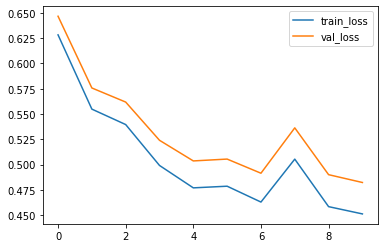

In [ ]:
plt.plot(losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.legend()
plt.show()

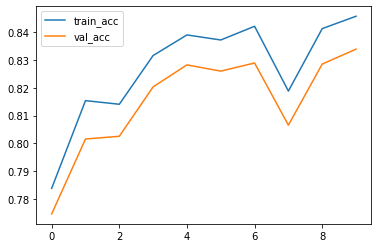

In [ ]:
plt.plot(accuracies, label="train_acc")
plt.plot(val_accuracies, label="val_acc")
plt.legend()
plt.show()

## Checking out predictions

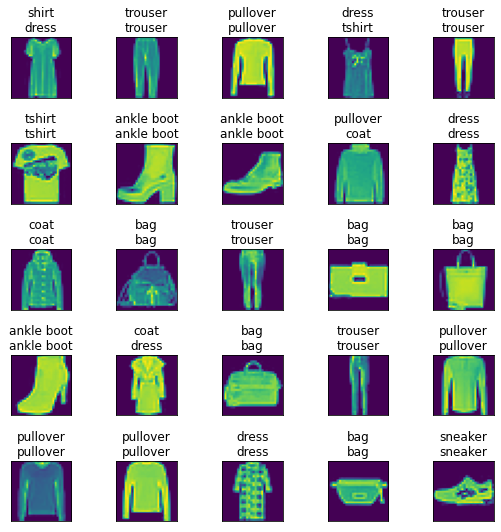

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=25, shuffle=True)))
pred = net(X).argmax(axis=1)
show_images(X.reshape(25, 28, 28), 5, 5, 
            titles=list([i+"\n"+j for i, j in zip(get_fmnist_labels(y),get_fmnist_labels(pred))])
)
plt.show()